# Analyse impact of salinity restoring relative to meltwater perturbation

In [6]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import cartopy.crs as ccrs
import xarray as xr
import cmocean.cm as cmocean
import glob
import matplotlib.path as mpath
import matplotlib.colors as col
from gsw import SA_from_SP, p_from_z

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client

figdir = '/g/data/v45/akm157/figures/IAF_meltwater/'

In [2]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 28,Total memory: 125.20 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43825,Workers: 7
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 125.20 GiB
Comm: tcp://127.0.0.1:36501,Total threads: 4
Dashboard: /proxy/42209/status,Memory: 17.89 GiB
Nanny: tcp://127.0.0.1:37889,


In [3]:
master_session = cc.database.create_session()

control = '01deg_jra55v140_iaf_cycle4'
iaf_melt = '01deg_jra55v140_iaf_cycle4_MWpert'

start_time='1979-01-01'
end_time='2018-12-31'

lat_slice  = slice(-80,-59)

In [14]:
# topography data for plotting:
ht = cc.querying.getvar(control,'ht' , master_session,n=1).sel(yt_ocean=lat_slice)
land_mask = np.squeeze(ht.values)*0
land_mask[np.isnan(land_mask)] = 1
land_mask = np.where(land_mask==1,land_mask,np.nan)
land_mask_masked = np.ma.masked_where((land_mask==0),land_mask)
# make land go all the way to -90S:
#land_mask_lat = ht.yt_ocean.values
#land_mask_lat[0] = -90

fontsize=15

## Time series of restoring over shelf:

In [24]:
# shelf masking:
contour_file = np.load('/g/data/ik11/grids/Antarctic_slope_contour_1000m.npz')
shelf_mask = contour_file['contour_masked_above']
yt_ocean = contour_file['yt_ocean']
xt_ocean = contour_file['xt_ocean']
# Mask values that are non-zero
shelf_mask[np.where(shelf_mask!=0)] = np.nan
shelf_mask = shelf_mask+1
shelf_mask = xr.DataArray(shelf_mask, coords = [('yt_ocean', yt_ocean), ('xt_ocean', xt_ocean)])

area_t = cc.querying.getvar(control, 'area_t', master_session,n=1).sel(yt_ocean=lat_slice)
area_t = (area_t*shelf_mask).load()
area_sum = area_t.sum(dim={'xt_ocean','yt_ocean'}).load()

In [15]:
# stuff needed for absolute salinity conversion:
st_ocean = cc.querying.getvar(control,'st_ocean',master_session,n=1).load()
geolon_t = cc.querying.getvar(control,'geolon_t',master_session, n=1).sel(yt_ocean=lat_slice).load()
geolat_t = cc.querying.getvar(control,'geolat_t',master_session, n=1).sel(yt_ocean=lat_slice).load()
depth_tile = -(geolat_t*0+1)*st_ocean[0].values
pressure = xr.DataArray(p_from_z(depth_tile,geolat_t), coords = [yt_ocean, xt_ocean], dims = ['yt_ocean', 'xt_ocean'], 
                        name = 'pressure', attrs = {'units':'dbar'})

In [25]:
SSS_prac = cc.querying.getvar(control, 'salt', master_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
SSS_prac = SSS_prac.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice).sel(st_ocean=0,method='nearest')
# convert units to absolute salinity:
SSS_con = xr.DataArray(SA_from_SP(SSS_prac,pressure,geolon_t,geolat_t), coords = [SSS_prac.time, SSS_prac.yt_ocean, SSS_prac.xt_ocean], 
                       dims = ['time','yt_ocean', 'xt_ocean'], name = 'sea surface salinity', 
                       attrs = {'units':'Absolute Salinity (g/kg)'})

restoring_con = cc.querying.getvar(control, 'sfc_salt_flux_restore', master_session, frequency='1 monthly',
                                   start_time=start_time, end_time=end_time)
restoring_con = restoring_con.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)
# need factor of 1000, because salt flux is in (kg of salt)/m^2/s, but SSS is in (g salt)/(kg of water)
restoring_con = restoring_con*1000/SSS_con

# restrict to shelf and integrate over area:
restoring_con = (restoring_con*area_t).sum('xt_ocean').sum('yt_ocean')/area_sum
restoring_con = restoring_con.load()

2022-09-15 11:10:48,864 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
2022-09-15 11:10:49,030 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
2022-09-15 11:10:49,194 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
2022-09-15 11:10:49,320 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2022-09-15 11:10:49,369 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
2022-09-15 11:10:49,412 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
2022-09-15 11:10:49,595 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
2022-09-15 11:10:49,782 - distributed.utils_perf - WARNING - full garbage collections took

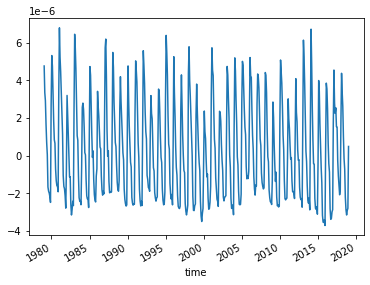

In [26]:
restoring_con.plot()

In [32]:
SSS_prac = cc.querying.getvar(iaf_melt, 'salt', master_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
SSS_prac = SSS_prac.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice).sel(st_ocean=0,method='nearest')
# convert units to absolute salinity:
SSS_melt = xr.DataArray(SA_from_SP(SSS_prac,pressure,geolon_t,geolat_t), coords = [SSS_prac.time, SSS_prac.yt_ocean, SSS_prac.xt_ocean], 
                       dims = ['time','yt_ocean', 'xt_ocean'], name = 'sea surface salinity', 
                       attrs = {'units':'Absolute Salinity (g/kg)'})

restoring_melt = cc.querying.getvar(iaf_melt, 'sfc_salt_flux_restore', master_session, frequency='1 monthly',
                                   start_time=start_time, end_time=end_time)
restoring_melt = restoring_melt.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)
# need factor of 1000, because salt flux is in (kg of salt)/m^2/s, but SSS is in (g salt)/(kg of water)
restoring_melt = restoring_melt*1000/SSS_melt

# restrict to shelf and integrate over area:
restoring_melt = (restoring_melt*area_t).sum('xt_ocean').sum('yt_ocean')/area_sum
restoring_melt = restoring_melt.load()

In [31]:
# compare to runoff:

runoff_con = cc.querying.getvar(control, 'runoff', master_session, frequency='1 monthly',
                                   start_time=start_time, end_time=end_time)
runoff_con = runoff_con.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)
# restrict to shelf and integrate over area:
runoff_con = (runoff_con*area_t).sum('xt_ocean').sum('yt_ocean')/area_sum
runoff_con = runoff_con.load()

runoff_melt = cc.querying.getvar(iaf_melt, 'runoff', master_session, frequency='1 monthly',
                                   start_time=start_time, end_time=end_time)
runoff_melt = runoff_melt.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)
# restrict to shelf and integrate over area:
runoff_melt = (runoff_melt*area_t).sum('xt_ocean').sum('yt_ocean')/area_sum
runoff_melt = runoff_melt.load()

(0.0, 2.1e-06)

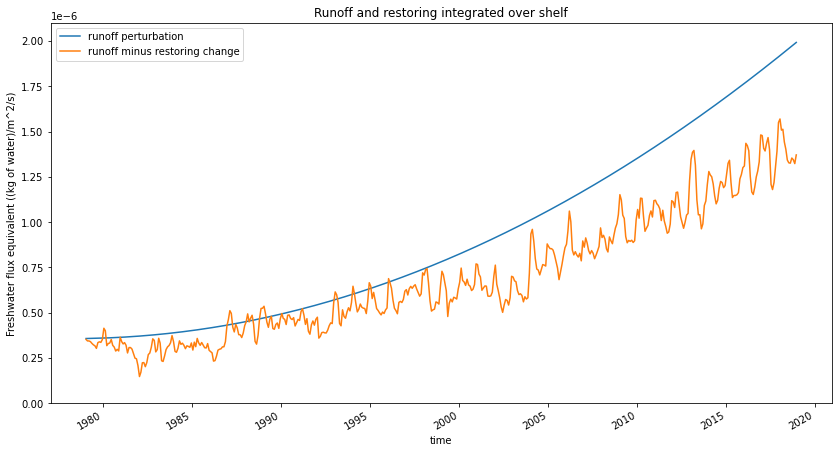

In [36]:
# units of both should be (kg of water)/m^2/s averaged over the shelf:

plt.figure(figsize=(14,7))
(runoff_melt - runoff_con).plot(label='runoff perturbation')
((runoff_melt - runoff_con)-(restoring_melt - restoring_con)).plot(label='runoff minus restoring change')
plt.legend()
plt.ylabel('Freshwater flux equivalent ((kg of water)/m^2/s)')
plt.title('Runoff and restoring integrated over shelf')
plt.ylim(0,2.1e-6)

In [38]:
((runoff_melt - runoff_con)-(restoring_melt - restoring_con))[-1]/(runoff_melt - runoff_con)[-1]

<xarray.DataArray ()>
array(0.68835659)
Coordinates:
    time     datetime64[ns] 2018-12-16T12:00:00